In [1]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset 
from torch.utils.data import DataLoader
import copy
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from collections import defaultdict
import pdb
import torch.distributions as tdist
import matplotlib
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [92]:
def gmm_sampler(num_samples, num_mixtures, mean, cov, mix_coeffs):
    z = np.random.multinomial(num_samples, mix_coeffs)

    samples = np.zeros(shape=[num_samples, len(mean[0])])
    target = np.zeros(shape=[num_samples])
    
    i_start = 0
    data = []
    for i in range(len(mix_coeffs)):
        i_end = i_start + z[i]
        samples[i_start:i_end, :] = np.random.multivariate_normal(
            mean=np.array(mean)[i, :],
            cov=np.diag(np.array(cov)[i, :]),            
            size=z[i])
        
        target[i_start:i_end] = i

        for j in range(i_start,i_end):
            data.append({"x":samples[j],"class":target[j]})
        i_start = i_end
   
    return data


class SynthDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, train_set_len, train_set):
        self.train_set_len = train_set_len
        self.train_set = train_set
    
    def __len__(self):
        return self.train_set_len  

    def __getitem__(self, idx):
        return self.train_set[idx]
        


In [93]:
nz = 10
ngf = 64
ndf = 64

inputdim=2
num_mixtures = 5
radius = 2.0
std = 0.01
thetas = np.linspace(0, 2 * np.pi, num_mixtures + 1)[:num_mixtures]
xs, ys = radius * np.sin(thetas), radius * np.cos(thetas)
mix_coeffs = [1./num_mixtures for i in range(num_mixtures)]
mean=tuple(zip(xs, ys))
cov=tuple([(std, std)] * num_mixtures)



In [114]:
div = 'Reverse-KL'
layer = 'map1'

In [115]:

batch_size = 64
train_set_len = 10000
train_set = gmm_sampler(train_set_len, num_mixtures, mean, cov, mix_coeffs)

synthdataset = SynthDataset(train_set_len, train_set)
dataloader = DataLoader(synthdataset, batch_size=batch_size,
                        shuffle=True, num_workers=4) 
if div == 'KL':
    def activation_func(x):
        return x

    def conjugate(x):
        return torch.exp(x - 1)

elif div == 'Reverse-KL':
    def activation_func(x):
        return -torch.exp(-x)

    def conjugate(x):
        return -1 - torch.log(-x)

elif div == 'JS':
    def activation_func(x):
        return torch.log(2.0 / (1 + torch.exp(-x)))

    def conjugate(x):
        return -torch.log(2 - torch.exp(x))
elif div == 'Pearson':
    def activation_func(x):
        return x

    def conjugate(x):
        return 0.25 * torch.pow(x, 2) + x
elif div == 'Total-Variation':
    def activation_func(x):
        return 0.5 * torch.tanh(x)

    def conjugate(x):
        return x


def g_loss(d_fake_score):
    g_loss_kl = -torch.mean(conjugate(activation_func(d_fake_score)))
    return g_loss_kl

def d_loss(d_real,d_fake):
    return -(torch.mean(activation_func(d_real)) - torch.mean(conjugate(activation_func(d_fake))))





In [116]:
device=torch.device('cuda')
class G(nn.Module):
    def __init__(self):
        super(G, self).__init__()   
        
        
        self.c1 = nn.Linear(nz, 128)
        self.c1_bn = nn.BatchNorm1d(128)
        self.c1_relu = nn.ReLU(True)
        self.c2 = nn.Linear(128, 128)
        self.c2_bn = nn.BatchNorm1d(128)
        self.c2_relu = nn.ReLU(True)
        self.c3 = nn.Linear(128, 2)
        self.c3_tanh = nn.Tanh()    
        
    def forward(self, input_1):
        output = self.c1_relu(self.c1_bn(self.c1(input_1)))
        output = self.c2_relu(self.c2_bn(self.c2(output)))
        output = self.c3(output) # removed tanh because we dont want bounding
        return output

        
class D(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(D, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.activation_fn = F.relu
        self.sigmoid_act = F.sigmoid

    def forward(self, x):
        x = self.activation_fn(self.map1(x))
        x = self.activation_fn(self.map2(x))
        return self.map3(x)
      

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        
netD = D(2,256,1)
netD.to(device)
netD.apply(weights_init)  
optimizerD = optim.Adam(netD.parameters(), lr=0.0001, betas=(0.5, 0.999))



netG = G()
netG.to(device)
netG.apply(weights_init)
optimizerG = optim.Adam(netG.parameters(), lr=0.0001, betas=(0.5, 0.999))

meanmatrix = np.matrix(mean)
import matplotlib.tri as tri
import matplotlib.mlab as mlab


In [117]:


def g_sample():
    with torch.no_grad():
        gen_input = torch.randn(batch_size*10, nz, device=device)
        g_fake_data = netG(gen_input)
        return g_fake_data.cpu().numpy()



In [118]:
    
Tensor = torch.cuda.FloatTensor
LongTensor = torch.cuda.LongTensor
grads=[]
xaxis=[]
stopeps = [1,2,5,10]

  0%|          | 0/11 [00:00<?, ?it/s]

0


  9%|▉         | 1/11 [00:02<00:21,  2.15s/it]

1
Entering deepcopy
6.536099


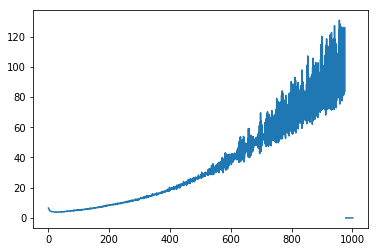

 18%|█▊        | 2/11 [00:09<00:43,  4.78s/it]

2
Entering deepcopy


 27%|██▋       | 3/11 [00:16<00:45,  5.66s/it]

9.903205
3


 36%|███▋      | 4/11 [00:19<00:33,  4.78s/it]

4


 45%|████▌     | 5/11 [00:21<00:25,  4.22s/it]

5
Entering deepcopy


 55%|█████▍    | 6/11 [00:27<00:23,  4.62s/it]

52.706757
6


 64%|██████▎   | 7/11 [00:30<00:17,  4.29s/it]

7


 73%|███████▎  | 8/11 [00:31<00:11,  4.00s/it]

8


 82%|████████▏ | 9/11 [00:33<00:07,  3.77s/it]

9


 91%|█████████ | 10/11 [00:35<00:03,  3.59s/it]

10
Entering deepcopy


100%|██████████| 11/11 [00:42<00:00,  3.89s/it]

156.75816


In [119]:
fig, ax = plt.subplots()

for epoch in tqdm(range(11)):
      print(epoch)
      for i, sample in enumerate(dataloader):
            points = Variable(sample['x'].type(Tensor))
            targets = Variable((sample['class']).type(LongTensor), requires_grad = False)        
            batch_size = points.size(0)

            z = torch.randn(batch_size, nz, device=device)

            valid = Variable(Tensor(points.size(0), 1).fill_(1.0), requires_grad=False)
            fake = Variable(Tensor(points.size(0), 1).fill_(0.0), requires_grad=False)

            real_points = Variable(points.type(Tensor), requires_grad = False) 

            # Update G

            optimizerG.zero_grad()
            gen_points = netG(z)
            output_d = netD(gen_points)
#             if div == 'JS':
#                 gloss = bce_loss(output_d, valid)
#             else:
            gloss = g_loss(output_d)
            gloss.backward()
            optimizerG.step()
        
            optimizerD.zero_grad()
            output_d_fake = netD(gen_points.detach())
            output_d_real = netD(real_points)
#             if div == 'JS':
#                 dloss_fake = bce_loss(output_d_fake, fake) 
#                 dloss_real = bce_loss(output_d_real, valid)
#                 dloss = (dloss_fake+dloss_real)/2.
#             else:
            dloss = d_loss(output_d_real, output_d_fake)
            dloss.backward()
            optimizerD.step()
        
            if epoch in stopeps and i==len(dataloader)-1:
                print("Entering deepcopy")
                netDcopy = D(2,256,1)
                netDcopy.to(device)
                netDcopy = copy.deepcopy(netD) 
                optimizerDcopy = optim.Adam(netDcopy.parameters(), lr=0.0001, betas=(0.5, 0.999))

                counter=1
                # Update D
                xaxis=[]
                grads=[]
                if layer == 'map1':
                    result=netD.map1.weight.grad.abs()
                elif layer == 'map3':
                    result=netD.map3.weight.grad.abs()
                grads.append(result.sum().cpu().numpy())
                xaxis.append(counter)                 
                for dsteps in range(1000):
                    counter+=1
                    optimizerDcopy.zero_grad()
                    output_d_fake = netDcopy(gen_points.detach())
                    output_d_real = netDcopy(real_points)
#                     if div == 'JS':
#                         dloss_fake = bce_loss(output_d_fake, fake) 
#                         dloss_real = bce_loss(output_d_real, valid)
#                         dloss = (dloss_fake+dloss_real)/2.
#                     else:
                    dloss = d_loss(output_d_real, output_d_fake)
                    dloss.backward()
                    optimizerDcopy.step()  
                    if layer == 'map1':
                        result=netDcopy.map1.weight.grad.abs()
                    elif layer == 'map3':
                        result=netDcopy.map3.weight.grad.abs()
                    grads.append(result.sum().cpu().numpy())
                    xaxis.append(counter)   
#                     if dsteps==999:

                ax.plot(xaxis,grads)
                print(grads[0])
#                         plt.xlabel('Training Iterations')
#                         plt.ylabel('Gradients (First layer)')
#                         ax.show()
                plt.show()


In [120]:
fig.legend(['Epoch 1','Epoch 2', 'Epoch 5', 'Epoch 10'])

In [121]:
if layer == 'map3':
    layername = 'last'
elif layer == 'map1':
    layername = 'first'

In [122]:
ax.set_ylabel('(Net sum) Gradients of '+layername+' Layer')
ax.set_xlabel('Unrolling Discriminator')
ax.set_title(div)
fig.savefig(div+'_'+layername+'_gradients.png')

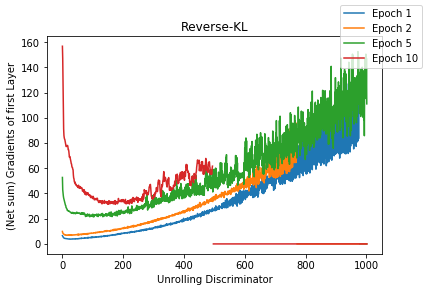

In [123]:
fig